# Задание 1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=10, suppress=True)
# robot parameters
params = {'l1': 0.7,
          'l2': 0.5}
gen_coords = {'q1': np.pi/8,
              'q2': np.pi/7}

In [ ]:
def Rx(q):
    T = np.array([[1,         0,          0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q),  np.cos(q), 0],
                  [0,         0,          0, 1]], dtype=float)
    return T


def Ry(q):
    T = np.array([[ np.cos(q), 0, np.sin(q), 0],
                  [         0, 1,         0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [         0, 0,         0, 1]], dtype=float)
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q),  np.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]], dtype=float)
    return T


def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]], dtype=float)
    return T

In [ ]:
def DH(d, theta, a, alpha):
    A = Rz(theta) @ Tz(d) @ Tx(a) @ Rx(alpha)
    return A

In [ ]:
d_p= np.array([params['l1'], 0])
th_p = np.array([np.pi/2, 0])
a_p = np.array([0, params['l2']])
al_p = np.array([np.pi/2, 0])

In [ ]:
def FK(q_cor):
    Matrix = np.eye(4)

    for i, q in enumerate(q_cor):
      Matrix = Matrix @ DH(d_p[i], th_p[i]+q, a_p[i], al_p[i])

    return Matrix

## analitical jacobian


Поэтому я предлагаю описывать ориентацию робота всего одним углом, который будет расчитываться как сумму углов на всех джоинтах:

$$ϕ=q_{1}+q_{2}$$


Положение и ориентация рабочего органа (end-effector) зписывается следующим образом:

\begin{equation}
l_{hand} = l_2 \cos(q_2) \\
z_{hand} = l_2 \sin(q_2) \\
x = l_{hand} \cos(q_1) \\
y = l_{hand} \sin(q_1) \\
z = z_{hand} + l1 \\
\varphi = q_1 + q_2
\end{equation}

In [ ]:
import sympy as sym

def j_sym_analytic():
  """
  The function returns the Jacobian (3x3) in symbolic form
  """
  x, y, z = sym.symbols('x, y, z')
  phi, q1, q2 = sym.symbols('varphi, q_1, q_2')
  l1,l2 = sym.symbols('l_1, l_2')

  l_hand = l2*sym.cos(q2)
  z_hand = l2*sym.sin(q2)

  x = l_hand*sym.cos(q1+np.pi/2)
  y = l_hand*sym.sin(q1+np.pi/2)
  z = z_hand + l1
  phi = q1 + q2

  J11 = sym.diff(x, q1)
  J12 = sym.diff(x, q2)

  J21 = sym.diff(y, q1)
  J22 = sym.diff(y, q2)

  J31 = sym.diff(z, q1)
  J32 = sym.diff(z, q2)

  J41 = sym.diff(phi, q1)
  J42 = sym.diff(phi, q2)

  J = sym.Matrix([[J11,J12], [J21,J22], [J31,J32], [J41,J42]])
  return J

In [ ]:
J = j_sym_analytic()
J

Matrix([
[-l_2*sin(q_1 + 1.5707963267949)*cos(q_2), -l_2*sin(q_2)*cos(q_1 + 1.5707963267949)],
[ l_2*cos(q_2)*cos(q_1 + 1.5707963267949), -l_2*sin(q_2)*sin(q_1 + 1.5707963267949)],
[                                       0,                             l_2*cos(q_2)],
[                                       1,                                        1]])

In [ ]:
from sympy import lambdify
q1,q2= sym.symbols('q_1, q_2')
l1,l2 = sym.symbols('l_1, l_2')

J_num = lambdify([q1, q2, l1, l2],J)

J_num(gen_coords['q1'], gen_coords['q2'], params['l1'], params['l2'])

array([[-0.4161933482,  0.0830200593],
       [-0.1723929294, -0.200428153 ],
       [ 0.          ,  0.450484434 ],
       [ 1.          ,  1.          ]])

## geometrical jacobian

In [ ]:
import numpy as np


def j_geometric(q_coords):
  """
  The function returns the Jacobian (6x3) calculated geometrically
  """
  pe = FK(q_coords)[:3, 3] # end-effector coordinates

  J = np.zeros((6, len(q_coords)))
  for i in range(len(q_coords)):
    pi = FK(q_coords[:i])[:3, 3]
    z = FK(q_coords[:i])[:3, 2]
    Jp = np.cross(z, (pe-pi))

    J[0:3,i] = Jp
    J[3:,i] = z

  return J

#points = get_points(np.array([0,0,0]))
J_gm = j_geometric(np.array([gen_coords['q1'],gen_coords['q2']]))
J_gm

array([[-0.4161933482,  0.0830200593],
       [-0.1723929294, -0.200428153 ],
       [ 0.          ,  0.450484434 ],
       [ 0.          ,  0.9238795325],
       [ 0.          ,  0.3826834324],
       [ 1.          ,  0.          ]])

## Numerical Jacobian

In [ ]:
def dRz(q):
    T = np.array([[-np.sin(q), -np.cos(q), 0, 0],
                  [np.cos(q),  -np.sin(q), 0, 0],
                  [        0,          0, 0, 0],
                  [        0,          0, 0, 0]], dtype=float)
    return T

def dRx(q):
    T = np.array([[0,         0,          0, 0],
                  [0, -np.sin(q), -np.cos(q), 0],
                  [0, np.cos(q),  -np.sin(q), 0],
                  [0,         0,          0, 0]], dtype=float)
    return T

def dRy(q):
    T = np.array([[ -np.sin(q), 0, np.cos(q), 0],
                  [         0, 0,         0, 0],
                  [-np.cos(q), 0, -np.sin(q), 0],
                  [         0, 0,         0, 0]], dtype=float)
    return T

In [ ]:
def j_numerical_derivatives(general_coordinates, robot_params):
  """
  The function returns the Jacobian (6x6) computed with numverical derivatives
  """
  q1, q2 = general_coordinates['q1'], general_coordinates['q2']
  l1, l2 = robot_params['l1'], robot_params['l2']

  # forward kinematics
  H = Rz(q1) @ Tz(l1) @ Rx(q2) @ Ty(l2)

  R = H[:3,:3]
  R_inv = R.T

  Hee_transposed = np.eye(4)
  Hee_transposed[:3,:3] = R_inv

  H1 = dRz(q1) @ Tz(l1) @ Rx(q2) @ Ty(l2) @ Hee_transposed
  J1 = np.array([H1[0,3],H1[1,3],H1[2,3], H1[2,1], H1[0,2], H1[1,0]]).reshape((6,1))

  H2 = Rz(q1) @ Tz(l1) @ dRx(q2) @ Ty(l2) @ Hee_transposed
  J2 = np.array([H2[0,3],H2[1,3],H2[2,3], H2[2,1], H2[0,2], H2[1,0]]).reshape((6,1))

  J = np.hstack([J1, J2])
  return J

j_numerical_derivatives(gen_coords, params)


array([[-0.4161933482,  0.0830200593],
       [-0.1723929294, -0.200428153 ],
       [ 0.          ,  0.450484434 ],
       [ 0.          ,  0.9238795325],
       [ 0.          ,  0.3826834324],
       [ 1.          , -0.          ]])

# Задание 2


In [ ]:
def time_params(params, t0 = 0):
  q0, qf, dq_max, ddq_max = params
  delta_q = qf - q0
  if np.sqrt(delta_q * ddq_max) <= dq_max:
    t1 = np.sqrt(delta_q / ddq_max)
    T = t1
    tf = 2*t1
    print(f'Triangle profile, minimum time: {tf} seconds.')
  else:
    t1 = dq_max / ddq_max
    T = delta_q / dq_max
    tf = t1 + T
    print(f'Trapezoidal profile, minimum time: {tf} seconds.')
  return t0, t1, T, tf

In [ ]:
from os import times
def plan_trajectory(q_params, t_params):
  t0, t1, T, tf = t_params
  q0, qf, dq_max, ddq_max = q_params
  time = np.linspace(t0,tf, int(1E3))
  dt = time[1]-time[0]
  q = []
  v = []
  a = []
  q_cur, dq_cur, ddq_cur = 0, 0, ddq_max

  # get the trajectory
  for t in time:
    q.append(q_cur)
    v.append(dq_cur)
    a.append(ddq_cur)
    if t < t1:
      q_cur += dq_cur *dt + ddq_cur / 2 * dt ** 2
      dq_cur += ddq_cur * dt

    if (t > t1) and (t < T):
      q_cur += dq_cur * dt
      dq_cur = dq_max
      ddq_cur = 0

    if t > T:
      q_cur += dq_cur *dt + ddq_cur / 2 * dt ** 2
      dq_cur += ddq_cur * dt
      ddq_cur = -ddq_max


  return time, q, v, a

Trapezoidal profile, minimum time: 11.5 seconds.
Trapezoidal profile, minimum time: 6.035714285714286 seconds.


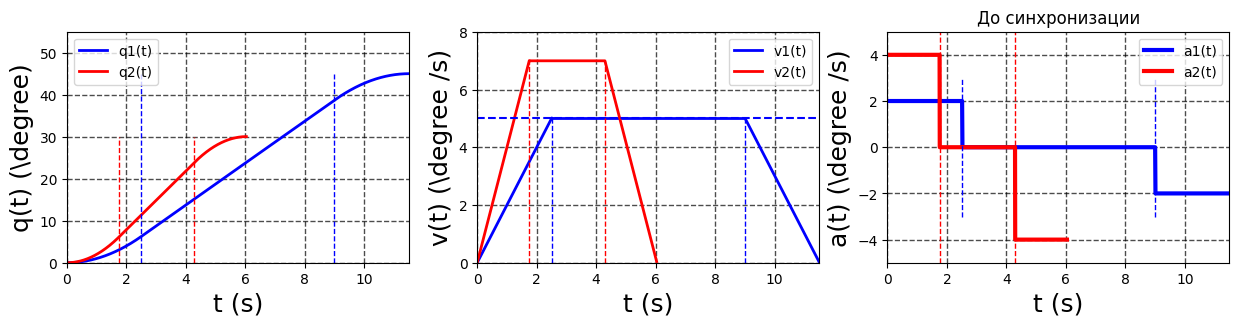

In [ ]:
# initial params [q0, qf, dq_m, ddq_m]
j1 = [0., 45., 5., 2.]
j2 = [0., 30., 7., 4.]

t0 = 0.

# calculate trajectory time for each joint
j1_t = time_params(j1)
j2_t = time_params(j2)

# calculate each trajectory
T1, q1, v1, a1 = plan_trajectory(j1, j1_t)
T2, q2, v2, a2 = plan_trajectory(j2, j2_t)

# extract time params for plotting
_, t11, T11, tf1 = j1_t
_, t12, T12, tf2 = j2_t

time_max = np.max([tf1,tf2])

plt.figure(figsize=(15,3))
plt.subplot(131)
plt.plot(T1,q1, linewidth=2, label="q1(t)",color='b')
plt.plot(T2,q2, linewidth=2, label="q2(t)", color='r')
plt.xlabel('t (s)', fontsize=18)
plt.ylabel(r'q(t) (\degree)', fontsize=18)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0,time_max])
plt.ylim([0,np.max([q1, q2])+10])
plt.vlines([t11,T11], 0, max(q1), linestyles='--', linewidth=1, color='b')
plt.vlines([t12,T12], 0, max(q2), linestyles='--', linewidth=1, color='r')
plt.legend()


plt.subplot(132)
plt.plot(T1,v1, linewidth=2, label="v1(t)", color='b')
plt.plot(T2,v2, linewidth=2, label="v2(t)", color='r')
plt.xlabel('t (s)', fontsize=18)
plt.ylabel(r'v(t) (\degree /s)', fontsize=18)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0,time_max])
plt.ylim([0,np.max([v1, v2])+1])
plt.hlines(j1[2], 0,tf1, linestyles='--', color='b', label=r"")
plt.vlines([t11,T11], 0, max(v1), linestyles='--', linewidth=1, color='b')
plt.vlines([t12,T12], 0, max(v2), linestyles='--', linewidth=1, color='r')
plt.legend()


plt.subplot(133)
plt.plot(T1,a1, linewidth=3, label="a1(t)", color='b')
plt.plot(T2,a2, linewidth=3, label="a2(t)", color='r')
plt.xlabel('t (s)', fontsize=18)
plt.ylabel(r'a(t) (\degree /s)', fontsize=18)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0, time_max])
plt.ylim([np.min([a1, a2])-1,np.max([a1, a2])+1])
plt.vlines([t11,T11], min(a1)-1, max(a1)+1, linestyles='--', linewidth=1, color='b')
plt.vlines([t12,T12], min(a2)-1, max(a2)+1, linestyles='--', linewidth=1, color='r')
plt.legend()
plt.title("До синхронизации")
plt.show()

In [ ]:
t0, tac, tconst, tdec = j1_t # j1_t had the maximal time
t_accel = tac-t0
t_vconst = tconst - tac
assert(t_accel == tdec- tconst)
vq2_max = (j2[1]-j1[0])/(t_vconst + t_accel)
aq2_max = vq2_max/ t_accel

vq1_max = (j1[1]-j1[0])/(t_vconst + t_accel)
aq1_max = vq1_max/ t_accel

Trapezoidal profile, minimum time: 11.5 seconds.
Trapezoidal profile, minimum time: 11.5 seconds.


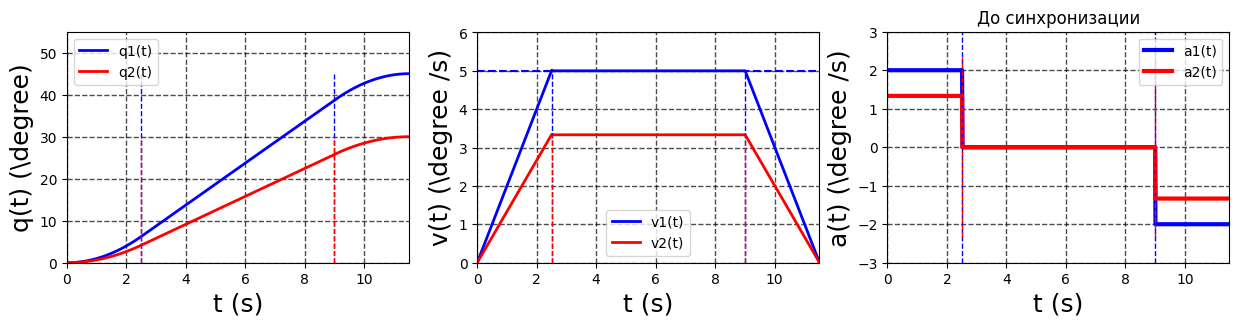

In [ ]:
# initial params [q0, qf, dq_m, ddq_m]
j1 = [0.,  45., vq1_max, aq1_max]
j2 = [0., 30., vq2_max, aq2_max]

t0 = 0.

# calculate trajectory time for each joint
j1_t = time_params(j1)
j2_t = time_params(j2)

# calculate each trajectory
T1, q1, v1, a1 = plan_trajectory(j1, j1_t)
T2, q2, v2, a2 = plan_trajectory(j2, j2_t)

# extract time params for plotting
_, t11, T11, tf1 = j1_t
_, t12, T12, tf2 = j2_t

time_max = np.max([tf1,tf2])

plt.figure(figsize=(15,3))
plt.subplot(131)
plt.plot(T1,q1, linewidth=2, label="q1(t)",color='b')
plt.plot(T2,q2, linewidth=2, label="q2(t)", color='r')
plt.xlabel('t (s)', fontsize=18)
plt.ylabel(r'q(t) (\degree)', fontsize=18)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0,time_max])
plt.ylim([0,np.max([q1, q2])+10])
plt.vlines([t11,T11], 0, max(q1), linestyles='--', linewidth=1, color='b')
plt.vlines([t12,T12], 0, max(q2), linestyles='--', linewidth=1, color='r')
plt.legend()


plt.subplot(132)
plt.plot(T1,v1, linewidth=2, label="v1(t)", color='b')
plt.plot(T2,v2, linewidth=2, label="v2(t)", color='r')
plt.xlabel('t (s)', fontsize=18)
plt.ylabel(r'v(t) (\degree /s)', fontsize=18)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0,time_max])
plt.ylim([0,np.max([v1, v2])+1])
plt.hlines(j1[2], 0,tf1, linestyles='--', color='b', label=r"")
plt.vlines([t11,T11], 0, max(v1), linestyles='--', linewidth=1, color='b')
plt.vlines([t12,T12], 0, max(v2), linestyles='--', linewidth=1, color='r')
plt.legend()


plt.subplot(133)
plt.plot(T1,a1, linewidth=3, label="a1(t)", color='b')
plt.plot(T2,a2, linewidth=3, label="a2(t)", color='r')
plt.xlabel('t (s)', fontsize=18)
plt.ylabel(r'a(t) (\degree /s)', fontsize=18)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0, time_max])
plt.ylim([np.min([a1, a2])-1,np.max([a1, a2])+1])
plt.vlines([t11,T11], min(a1)-1, max(a1)+1, linestyles='--', linewidth=1, color='b')
plt.vlines([t12,T12], min(a2)-1, max(a2)+1, linestyles='--', linewidth=1, color='r')
plt.legend()
plt.title("До синхронизации")
plt.show()

# Задание 3 (ДИНАМИКА)

In [ ]:
import sympy as sym
import numpy as np
def Rx_sym(q):
    T = sym.Matrix([[1,         0,          0, 0],
                  [0, sym.cos(q), -sym.sin(q), 0],
                  [0, sym.sin(q),  sym.cos(q), 0],
                  [0,         0,          0, 1]])
    return T

def Ry_sym(q):
    T = sym.Matrix([[ sym.cos(q), 0, sym.sin(q), 0],
                  [         0, 1,         0, 0],
                  [-sym.sin(q), 0, sym.cos(q), 0],
                  [         0, 0,         0, 1]])
    return T


def Rz_sym(q):
    T = sym.Matrix([[sym.cos(q), -sym.sin(q), 0, 0],
                  [sym.sin(q),  sym.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]])
    return T


def Tx_sym(x):
    T = sym.Matrix([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def Ty_sym(y):
    T = sym.Matrix([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def Tz_sym(z):
    T = sym.Matrix([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]])
    return T


def dRz(q):
    T = np.array([[-np.sin(q), -np.cos(q), 0, 0],
                  [np.cos(q),  -np.sin(q), 0, 0],
                  [        0,          0, 0, 0],
                  [        0,          0, 0, 0]], dtype=float)
    return T

def dRx(q):
    T = np.array([[0,         0,          0, 0],
                  [0, -np.sin(q), -np.cos(q), 0],
                  [0, np.cos(q),  -np.sin(q), 0],
                  [0,         0,          0, 0]], dtype=float)
    return T

def dRy(q):
    T = np.array([[ -np.sin(q), 0, np.cos(q), 0],
                  [         0, 0,         0, 0],
                  [-np.cos(q), 0, -np.sin(q), 0],
                  [         0, 0,         0, 0]], dtype=float)
    return T

In [ ]:
def DH(d, theta, a, alpha):
    A = Rz_sym(theta) @ Tz_sym(d) @ Tx_sym(a) @ Rx_sym(alpha)
    return A

In [ ]:
import matplotlib.pyplot as plt
np.set_printoptions(precision=10, suppress=True)
# robot parameters
l1_sym, l2_sym, lc1_sym, lc2_sym = sym.symbols('l_1, l_2, l_{c1}, l_{c2}')
# I1_sym, I2_sym = sym.symbols('I_1, I_2')

I_xx1, I_yy1, I_zz1 = sym.symbols('I_{xx1}, I_{yy1}, I_{zz1}')
I_xx2, I_yy2, I_zz2 = sym.symbols('I_{xx2}, I_{yy2}, I_{zz2}')
I1_sym = sym.Matrix([[I_xx1, 0, 0],
                     [0, I_yy1, 0],
                     [0,0, I_zz1]])

I2_sym = sym.Matrix([[I_xx2, 0, 0],
                     [0, I_yy2, 0],
                     [0,0, I_zz2]])

m1_sym, m2_sym = sym.symbols('m_1, m_2')
t = sym.symbols('t')
q1 = sym.Function('q1')(t)
q2 = sym.Function('q2')(t)
dq1 = sym.diff(q1, t)
dq2 = sym.diff(q2, t)
dq_start = sym.Matrix([dq1, dq2])
funny_pi = sym.symbols(r'\frac{pi}{2}')
g = sym.Symbol('g')

params = {'l1': l1_sym,
          'l2': l2_sym,
          'd1': lc1_sym}
gen_coords = {'q1': np.pi/8,
              'q2': 0.3}

q_0 = sym.Matrix([gen_coords['q1'],gen_coords['q2']])

In [ ]:
d_p= np.array([params['l1'], 0])
th_p = np.array([np.pi/2, 0])
a_p = np.array([0, params['l2']])
al_p = np.array([np.pi/2, 0])
q_type = np.array(["R", "R"])

In [ ]:
def FK(q_cor, q_type):
    Matrix = sym.eye(4)

    for i, (q, j_t) in enumerate(zip(q_cor, q_type)):
      Matrix = Matrix @ DH(d_p[i], th_p[i]+q, a_p[i], al_p[i])

    return Matrix

In [ ]:
from IPython.display import display
q_start = sym.Matrix([q1, q2])
num_coors = 2
FK0 = FK(q_start[:num_coors ], q_type[:num_coors ])
FK0.simplify()
FK0 = sym.nsimplify(FK0, tolerance=1e-10, rational=True)
display(FK0)

Matrix([
[cos(q1(t) + 9978066541/6352234450)*cos(q2(t)), -sin(q2(t))*cos(q1(t) + 9978066541/6352234450),  sin(q1(t) + 9978066541/6352234450), l_2*cos(q1(t) + 9978066541/6352234450)*cos(q2(t))],
[sin(q1(t) + 9978066541/6352234450)*cos(q2(t)), -sin(q1(t) + 9978066541/6352234450)*sin(q2(t)), -cos(q1(t) + 9978066541/6352234450), l_2*sin(q1(t) + 9978066541/6352234450)*cos(q2(t))],
[                                   sin(q2(t)),                                     cos(q2(t)),                                   0,                              l_1 + l_2*sin(q2(t))],
[                                            0,                                              0,                                   0,                                                 1]])

In [ ]:
def FK_com(q_cor, q_type):
    Matrix = sym.eye(4)
    Matrix = FK(q_cor[:-1], q_type[:-1])
    joint_num = len(q_cor)-1

    if joint_num <0:
      return Matrix
    elif joint_num == 0:
        Matrix = Matrix @ DH(lc1_sym, 0, 0, 0) # the rotation after does not matter
    elif joint_num == 1:
        Matrix = Matrix @ DH(d_p[joint_num], th_p[joint_num]+q_cor[-1], lc2_sym, 0) # the rotation after does not matter


    return Matrix

In [ ]:
num_coors = 2
FK0 = FK_com(q_start[:num_coors ], q_type[:num_coors ])
FK0.simplify()
FK0 = sym.nsimplify(FK0, tolerance=1e-10, rational=True)
display(FK0)

Matrix([
[cos(q1(t) + 9978066541/6352234450)*cos(q2(t)), -sin(q2(t))*cos(q1(t) + 9978066541/6352234450),  sin(q1(t) + 9978066541/6352234450), l_{c2}*cos(q1(t) + 9978066541/6352234450)*cos(q2(t))],
[sin(q1(t) + 9978066541/6352234450)*cos(q2(t)), -sin(q1(t) + 9978066541/6352234450)*sin(q2(t)), -cos(q1(t) + 9978066541/6352234450), l_{c2}*sin(q1(t) + 9978066541/6352234450)*cos(q2(t))],
[                                   sin(q2(t)),                                     cos(q2(t)),                                   0,                              l_1 + l_{c2}*sin(q2(t))],
[                                            0,                                              0,                                   0,                                                    1]])

geometric jacobian for the generic mass

In [ ]:
import numpy as np
def j_geometric(q_coords, q_type):
  """
  The function returns the Jacobian (6x2) calculated geometrically
  """
  pe = FK(q_coords, q_type)[:3, 3].T # end-effector coordinates

  J = sym.zeros(6, 2)
  for i in range(len(q_coords)):
    if q_type[i] == "R":
      pi = FK(q_coords[:i], q_type)[:3, 3].T
      z = FK(q_coords[:i], q_type)[:3, 2].T
      Jp = z.cross(pe-pi)
      J[0:3,i] = Jp.T
      J[3:,i] = z.T
    elif q_type[i] == "P":
      z = FK(q_coords[:i], q_type)[:3, 2].T
      J[0:3,i] = z.T

  return J

#points = get_points(np.array([0,0,0]))
J_gm = sym.nsimplify(j_geometric(q_start, q_type), tolerance=1e-10,rational=True)
J_gm

Matrix([
[-l_2*sin(q1(t) + 9978066541/6352234450)*cos(q2(t)),                                                          -l_2*sin(q2(t))*cos(q1(t) + 9978066541/6352234450)],
[ l_2*cos(q1(t) + 9978066541/6352234450)*cos(q2(t)),                                                          -l_2*sin(q1(t) + 9978066541/6352234450)*sin(q2(t))],
[                                                 0, l_2*sin(q1(t) + 9978066541/6352234450)**2*cos(q2(t)) + l_2*cos(q1(t) + 9978066541/6352234450)**2*cos(q2(t))],
[                                                 0,                                                                          sin(q1(t) + 9978066541/6352234450)],
[                                                 0,                                                                         -cos(q1(t) + 9978066541/6352234450)],
[                                                 1,                                                                                                           0]])

In [ ]:
import numpy as np
def j_geometric_com(q_coords, q_type):
  """
  The function returns the Jacobian (6x2) calculated geometrically
  """
  pe = FK_com(q_coords, q_type)[:3, 3].T # end-effector coordinates

  J = sym.zeros(6, 2)
  for i in range(len(q_coords)):
    if q_type[i] == "R":
      pi = FK(q_coords[:i], q_type)[:3, 3].T
      z = FK(q_coords[:i], q_type)[:3, 2].T
      Jp = z.cross(pe-pi)
      J[0:3,i] = Jp.T
      J[3:,i] = z.T
    elif q_type[i] == "P":
      z = FK_com(q_coords[:i+1], q_type)[:3, 2].T
      display(sym.nsimplify(FK_com(q_coords[:i+1], q_type), tolerance=1e-10,rational=True))
      J[0:3,i] = z.T

  return J

J1 = sym.nsimplify(j_geometric_com(q_start[:1], q_type[:1]), tolerance=1e-10,rational=True)
J2 = sym.nsimplify(j_geometric_com(q_start, q_type), tolerance=1e-10,rational=True)
Rcom1 =  FK_com(q_start[:1], q_type[:1])[:3, :3]
Rcom2 =  FK_com(q_start, q_type)[:3, :3]

In [ ]:
J1v, J1w = J1[:3, :], J1[3:, :]
J2v, J2w = J2[:3, :], J2[3:, :]

In [ ]:
J2

Matrix([
[-l_{c2}*sin(q1(t) + 9978066541/6352234450)*cos(q2(t)),                                                             -l_{c2}*sin(q2(t))*cos(q1(t) + 9978066541/6352234450)],
[ l_{c2}*cos(q1(t) + 9978066541/6352234450)*cos(q2(t)),                                                             -l_{c2}*sin(q1(t) + 9978066541/6352234450)*sin(q2(t))],
[                                                    0, l_{c2}*sin(q1(t) + 9978066541/6352234450)**2*cos(q2(t)) + l_{c2}*cos(q1(t) + 9978066541/6352234450)**2*cos(q2(t))],
[                                                    0,                                                                                sin(q1(t) + 9978066541/6352234450)],
[                                                    0,                                                                               -cos(q1(t) + 9978066541/6352234450)],
[                                                    1,                                                                            

In [ ]:
Mcom1 = m1_sym * J1v.T @ J1v + J1w.T @ Rcom1 @ I1_sym @ Rcom1.T @ J1w
Mcom1 = sym.nsimplify(Mcom1, tolerance=1e-10,rational=True)
Mcom1 = Mcom1.simplify()
Mcom1

Matrix([
[I_{zz1}, 0],
[      0, 0]])

In [ ]:
Mcom2 = m2_sym * J2v.T @ J2v + J2w.T @ Rcom2 @ I2_sym @ Rcom2.T @ J2w
Mcom2 = sym.nsimplify(Mcom2, tolerance=1e-10,rational=True)
Mcom2 = Mcom2.simplify()
Mcom2

Matrix([
[-I_{xx2}*cos(q2(t))**2 + I_{xx2} + I_{yy2}*cos(q2(t))**2 + l_{c2}**2*m_2*cos(q2(t))**2,                       0],
[                                                                                     0, I_{zz2} + l_{c2}**2*m_2]])

In [ ]:
M = Mcom1 + Mcom2
M = sym.nsimplify(M, tolerance=1e-10,rational=True)
M = M.simplify()
M

Matrix([
[-I_{xx2}*cos(q2(t))**2 + I_{xx2} + I_{yy2}*cos(q2(t))**2 + I_{zz1} + l_{c2}**2*m_2*cos(q2(t))**2,                       0],
[                                                                                               0, I_{zz2} + l_{c2}**2*m_2]])

In [ ]:
M

Matrix([
[-I_{xx2}*cos(q2(t))**2 + I_{xx2} + I_{yy2}*cos(q2(t))**2 + I_{zz1} + l_{c2}**2*m_2*cos(q2(t))**2,                       0],
[                                                                                               0, I_{zz2} + l_{c2}**2*m_2]])

In [ ]:
M_lam = sym.lambdify([q2, I_xx2, I_yy2, I_zz1, I_zz2,  lc2_sym, m2_sym], M)
M_lam(0, 1e-3, 6 * 1e-3, 6 * 1e-3, 6 * 1e-3, 0.25, 0.2)

array([[0.0245, 0.    ],
       [0.    , 0.0185]])

In [ ]:
dim = len(q_start)

coriolis = sym.zeros(dim, dim)
for i in range(dim):
  for j in range(dim):
    for k in range(dim):
      coriolis[i, j] += 1/2*(sym.diff(M[i, j], q_start[k])+sym.diff(M[i, k], q_start[j])-sym.diff(M[j, k], q_start[i])) * dq_start[k]


In [ ]:
coriolis = sym.nsimplify(coriolis, tolerance=1e-10,rational=True)
coriolis = coriolis.simplify()
coriolis

Matrix([
[ (I_{xx2} - I_{yy2} - l_{c2}**2*m_2)*sin(2*q2(t))*Derivative(q2(t), t)/2, (I_{xx2} - I_{yy2} - l_{c2}**2*m_2)*sin(2*q2(t))*Derivative(q1(t), t)/2],
[(-I_{xx2} + I_{yy2} + l_{c2}**2*m_2)*sin(2*q2(t))*Derivative(q1(t), t)/2,                                                                       0]])

In [ ]:
coriolis_lam = sym.lambdify([q2, dq1, dq2, I_xx2, I_yy2, I_zz1, I_zz2,  lc2_sym, m2_sym], coriolis)
coriolis_lam(np.pi/2, 1, 1,  1e-3, 6 * 1e-3, 6 * 1e-3, 6 * 1e-3, 0.25, 0.2)

array([[-0., -0.],
       [ 0.,  0.]])

In [ ]:
J2v

Matrix([
[-l_{c2}*sin(q1(t) + 9978066541/6352234450)*cos(q2(t)),                                                             -l_{c2}*sin(q2(t))*cos(q1(t) + 9978066541/6352234450)],
[ l_{c2}*cos(q1(t) + 9978066541/6352234450)*cos(q2(t)),                                                             -l_{c2}*sin(q1(t) + 9978066541/6352234450)*sin(q2(t))],
[                                                    0, l_{c2}*sin(q1(t) + 9978066541/6352234450)**2*cos(q2(t)) + l_{c2}*cos(q1(t) + 9978066541/6352234450)**2*cos(q2(t))]])

In [ ]:
g = sym.Symbol('g')
g0 = sym.Matrix([0, 0, g])
gravity = -J1v.T @ g0 * m1_sym - J2v.T @ g0 * m2_sym
gravity

Matrix([
[                                                                                                                         0],
[-g*m_2*(l_{c2}*sin(q1(t) + 9978066541/6352234450)**2*cos(q2(t)) + l_{c2}*cos(q1(t) + 9978066541/6352234450)**2*cos(q2(t)))]])

In [ ]:
gravity_lam = sym.lambdify([q1, q2, lc2_sym, m2_sym, g], gravity)
gravity_lam(np.pi/2, np.pi/2,   0.25, 0.2, 9.81)

array([[ 0.],
       [-0.]])

In [ ]:
q_start

Matrix([
[q1(t)],
[q2(t)]])

In [ ]:
tau = M @ q_start + coriolis @ q_start + gravity
tau

Matrix([
[(I_{xx2} - I_{yy2} - l_{c2}**2*m_2)*q1(t)*sin(2*q2(t))*Derivative(q2(t), t)/2 + (I_{xx2} - I_{yy2} - l_{c2}**2*m_2)*q2(t)*sin(2*q2(t))*Derivative(q1(t), t)/2 + (-I_{xx2}*cos(q2(t))**2 + I_{xx2} + I_{yy2}*cos(q2(t))**2 + I_{zz1} + l_{c2}**2*m_2*cos(q2(t))**2)*q1(t)],
[                           -g*m_2*(l_{c2}*sin(q1(t) + 9978066541/6352234450)**2*cos(q2(t)) + l_{c2}*cos(q1(t) + 9978066541/6352234450)**2*cos(q2(t))) + (I_{zz2} + l_{c2}**2*m_2)*q2(t) + (-I_{xx2} + I_{yy2} + l_{c2}**2*m_2)*q1(t)*sin(2*q2(t))*Derivative(q1(t), t)/2]])

In [ ]:
tau = sym.nsimplify(tau, tolerance=1e-10,rational=True)
tau = tau.simplify()
tau

Matrix([
[-(-I_{xx2} + I_{yy2} + l_{c2}**2*m_2)*q1(t)*sin(2*q2(t))*Derivative(q2(t), t)/2 - (-I_{xx2} + I_{yy2} + l_{c2}**2*m_2)*q2(t)*sin(2*q2(t))*Derivative(q1(t), t)/2 + (-I_{xx2}*cos(q2(t))**2 + I_{xx2} + I_{yy2}*cos(q2(t))**2 + I_{zz1} + l_{c2}**2*m_2*cos(q2(t))**2)*q1(t)],
[                                                                                                                                -g*l_{c2}*m_2*cos(q2(t)) + (I_{zz2} + l_{c2}**2*m_2)*q2(t) + (-I_{xx2} + I_{yy2} + l_{c2}**2*m_2)*q1(t)*sin(2*q2(t))*Derivative(q1(t), t)/2]])

In [ ]:
tau_lam = sym.lambdify([q1, q2, dq1, dq2, I_xx2, I_yy2, I_zz1, I_zz2,  lc2_sym, m2_sym, g], tau)
tau_lam(np.pi/2, np.pi/2, 1, 1,  1e-3, 6 * 1e-3, 6 * 1e-3, 6 * 1e-3, 0.25, 0.2, 9.81)

array([[0.0109955743],
       [0.029059732 ]])

Проверка

In [ ]:
sym.diff(M, t)

Matrix([
[2*I_{xx2}*sin(q2(t))*cos(q2(t))*Derivative(q2(t), t) - 2*I_{yy2}*sin(q2(t))*cos(q2(t))*Derivative(q2(t), t) - 2*l_{c2}**2*m_2*sin(q2(t))*cos(q2(t))*Derivative(q2(t), t), 0],
[                                                                                                                                                                       0, 0]])

In [ ]:
2*coriolis

Matrix([
[ (I_{xx2} - I_{yy2} - l_{c2}**2*m_2)*sin(2*q2(t))*Derivative(q2(t), t), (I_{xx2} - I_{yy2} - l_{c2}**2*m_2)*sin(2*q2(t))*Derivative(q1(t), t)],
[(-I_{xx2} + I_{yy2} + l_{c2}**2*m_2)*sin(2*q2(t))*Derivative(q1(t), t),                                                                     0]])

In [ ]:
A = sym.diff(M, t) - 2*coriolis
A = sym.simplify(A)
A

Matrix([
[                                                                    0, (-I_{xx2} + I_{yy2} + l_{c2}**2*m_2)*sin(2*q2(t))*Derivative(q1(t), t)],
[(I_{xx2} - I_{yy2} - l_{c2}**2*m_2)*sin(2*q2(t))*Derivative(q1(t), t),                                                                      0]])

In [ ]:
sym.simplify(A.T + A)

Matrix([
[0, 0],
[0, 0]])

# Задание 4

Kinetic energy

In [ ]:
dq_start.T @ M  @ dq_start * (1/2)

Matrix([[0.5*(I_{zz2} + l_{c2}**2*m_2)*Derivative(q2(t), t)**2 + 0.5*(-I_{xx2}*cos(q2(t))**2 + I_{xx2} + I_{yy2}*cos(q2(t))**2 + I_{zz1} + l_{c2}**2*m_2*cos(q2(t))**2)*Derivative(q1(t), t)**2]])

Potential energy

In [ ]:
Pcom1 =  FK_com(q_start[:1], q_type[:1])[:3, 3]
Pcom2 =  sym.simplify(FK_com(q_start, q_type))[:3, 3]
Pcom2 = sym.nsimplify(Pcom2, tolerance=1e-10,rational=True)

In [ ]:
Pcom1

Matrix([
[     0],
[     0],
[l_{c1}]])

In [ ]:
Pcom2

Matrix([
[l_{c2}*cos(q1(t) + 9978066541/6352234450)*cos(q2(t))],
[l_{c2}*sin(q1(t) + 9978066541/6352234450)*cos(q2(t))],
[                             l_1 + l_{c2}*sin(q2(t))]])

In [ ]:
g0

Matrix([
[0],
[0],
[g]])

In [ ]:
potential = -(m1_sym * g0.T @ Pcom1 + m2_sym * g0.T @ Pcom2)
potential

Matrix([[-g*l_{c1}*m_1 - g*m_2*(l_1 + l_{c2}*sin(q2(t)))]])

# Задание 5

Надо добавить в гравитационный вектор воздействие на энд эффектор

In [ ]:
Fx, Fy, Fz = sym.symbols('F_x, F_y, F_z')
Force_end_eff = sym.Matrix([Fx, Fy, Fz])

In [ ]:
Jee = sym.nsimplify(j_geometric(q_start[:], q_type[:]), tolerance=1e-10,rational=True)
Jeev, Jeew = Jee[:3, :], Jee[3:, :]

In [ ]:
Jeev

Matrix([
[-l_2*sin(q1(t) + 9978066541/6352234450)*cos(q2(t)),                                                          -l_2*sin(q2(t))*cos(q1(t) + 9978066541/6352234450)],
[ l_2*cos(q1(t) + 9978066541/6352234450)*cos(q2(t)),                                                          -l_2*sin(q1(t) + 9978066541/6352234450)*sin(q2(t))],
[                                                 0, l_2*sin(q1(t) + 9978066541/6352234450)**2*cos(q2(t)) + l_2*cos(q1(t) + 9978066541/6352234450)**2*cos(q2(t))]])

In [ ]:
external_forces = -Jeev.T @ Force_end_eff
external_forces

Matrix([
[                                                                                                                     F_x*l_2*sin(q1(t) + 9978066541/6352234450)*cos(q2(t)) - F_y*l_2*cos(q1(t) + 9978066541/6352234450)*cos(q2(t))],
[F_x*l_2*sin(q2(t))*cos(q1(t) + 9978066541/6352234450) + F_y*l_2*sin(q1(t) + 9978066541/6352234450)*sin(q2(t)) + F_z*(-l_2*sin(q1(t) + 9978066541/6352234450)**2*cos(q2(t)) - l_2*cos(q1(t) + 9978066541/6352234450)**2*cos(q2(t)))]])

In [ ]:
tau = M @ q_start + coriolis @ q_start + gravity + external_forces
tau = sym.nsimplify(tau, tolerance=1e-10,rational=True)
tau = tau.simplify()
tau

Matrix([
[F_x*l_2*sin(q1(t) + 9978066541/6352234450)*cos(q2(t)) - F_y*l_2*cos(q1(t) + 9978066541/6352234450)*cos(q2(t)) - (-I_{xx2} + I_{yy2} + l_{c2}**2*m_2)*q1(t)*sin(2*q2(t))*Derivative(q2(t), t)/2 - (-I_{xx2} + I_{yy2} + l_{c2}**2*m_2)*q2(t)*sin(2*q2(t))*Derivative(q1(t), t)/2 + (-I_{xx2}*cos(q2(t))**2 + I_{xx2} + I_{yy2}*cos(q2(t))**2 + I_{zz1} + l_{c2}**2*m_2*cos(q2(t))**2)*q1(t)],
[                                                                                                           F_x*l_2*sin(q2(t))*cos(q1(t) + 9978066541/6352234450) + F_y*l_2*sin(q1(t) + 9978066541/6352234450)*sin(q2(t)) - F_z*l_2*cos(q2(t)) - g*l_{c2}*m_2*cos(q2(t)) + (I_{zz2} + l_{c2}**2*m_2)*q2(t) + (-I_{xx2} + I_{yy2} + l_{c2}**2*m_2)*q1(t)*sin(2*q2(t))*Derivative(q1(t), t)/2]])